In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import warp_polar, rotate
import os
import pandas as pd
import math
# np.set_printoptions(threshold=sys.maxsize)

print(cv2.__version__)

4.5.1


In [5]:
file_names = os.listdir("images")
file_names = ["images\{}".format(name) for name in file_names]

cb_images =list()
cropped_images= list()
original_images = list()
for file_name in file_names:
    image = cv2.imread(file_name)
    cropped_image= image[40:550,130:650]
    cropped_image[0:30,0:30]= 0
    cropped_images.append(cropped_image.copy())
    blurred_image = cv2.GaussianBlur(cropped_image,(13,13),0)
    cb_images.append(blurred_image)
    
 

In [8]:

def find_best_circle(img):
    circles = cv2.HoughCircles(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cv2.HOUGH_GRADIENT,2.0,minDist=190,
                                    param1=104,param2=400,minRadius=220,maxRadius=250)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        return circles

def compute_centroid(img,x_center, y_center,area):
    x_accumulator = y_accumulator=0
    counter = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j]>= 60:
                x_accumulator += i 
                y_accumulator += j 
    x = np.rint(x_accumulator/area)
    y = np.rint(y_accumulator/area)

    return (int(y),int(x))


def compute_rotation_angle(x,y):
    res = np.arctan2(y,x)*180/np.pi
    if y>=0 and x>=0:
        return res+90
    elif y>=0 and x<=0:
        return res+90
    elif y<=0 and x>=0:
        return np.abs(90+res)
    elif y<=0 and x<=0:
        return res+90



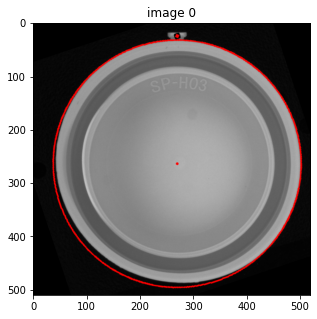

####################################################


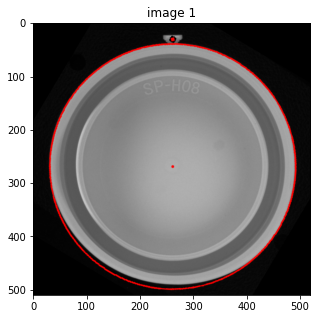

####################################################


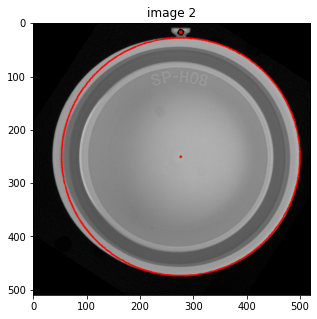

####################################################


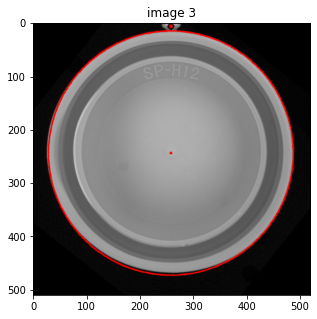

####################################################


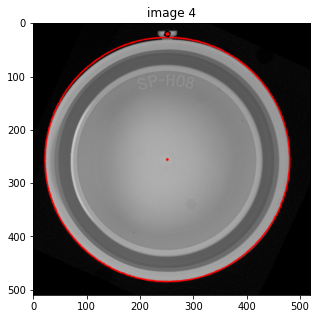

####################################################


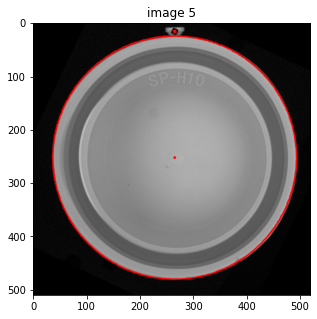

####################################################


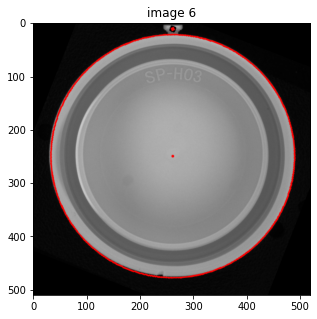

####################################################


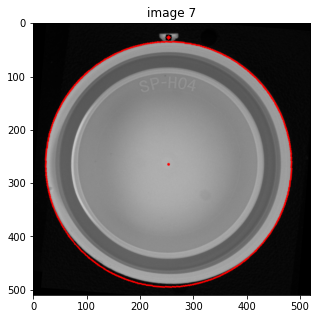

####################################################


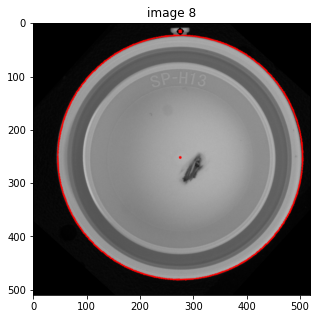

####################################################


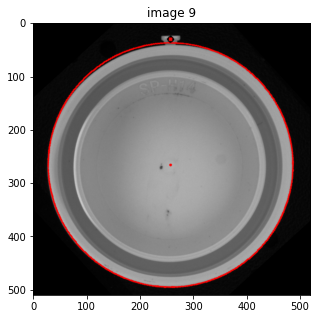

####################################################


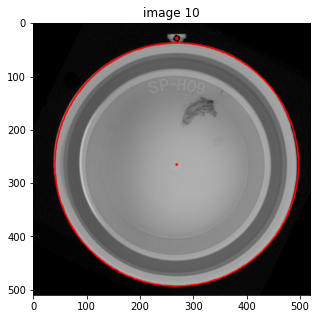

####################################################


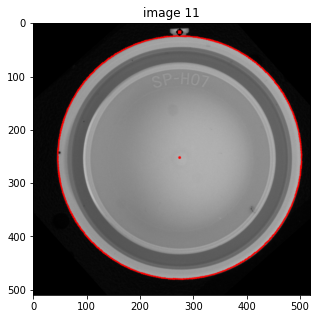

####################################################


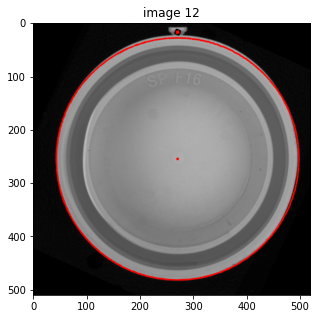

####################################################


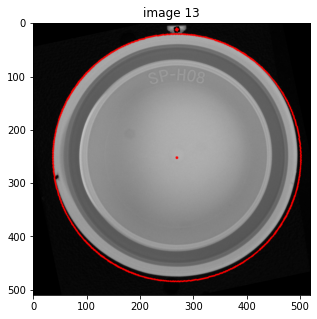

####################################################


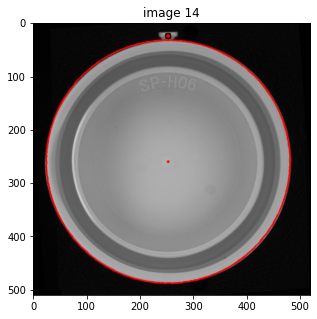

####################################################


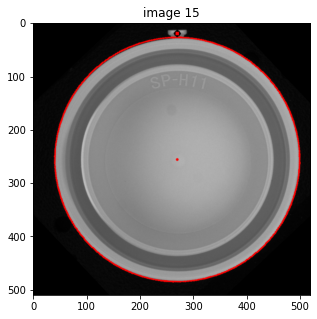

####################################################


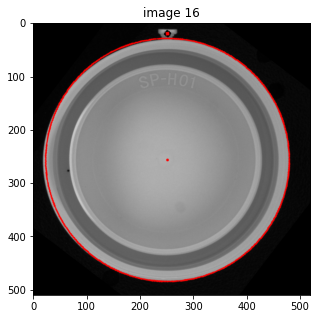

####################################################


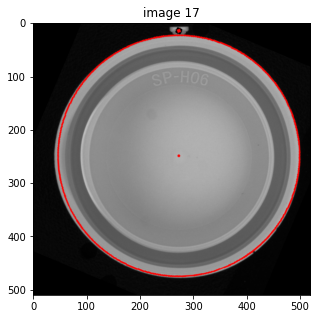

####################################################


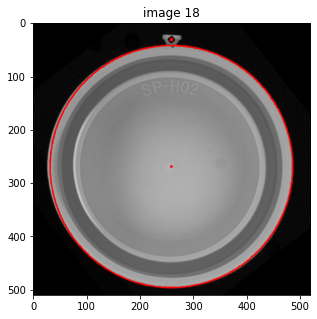

####################################################


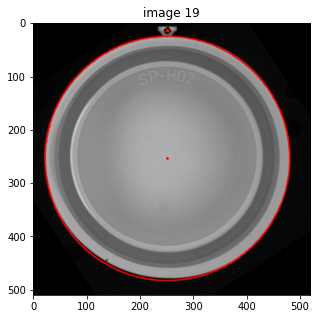

####################################################


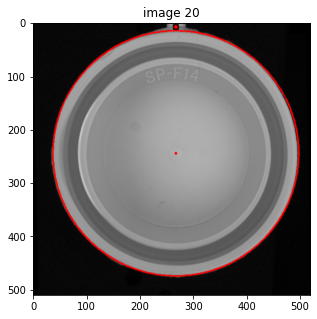

####################################################


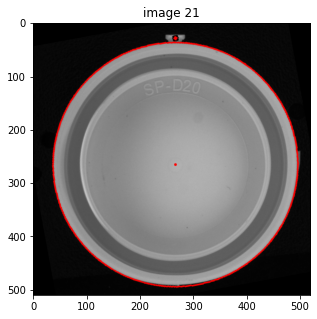

####################################################


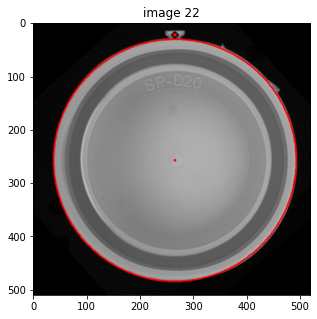

####################################################


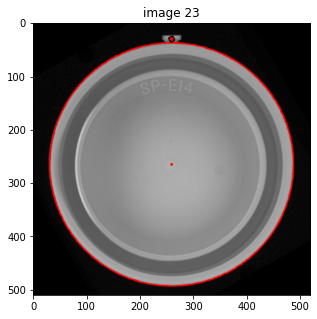

####################################################


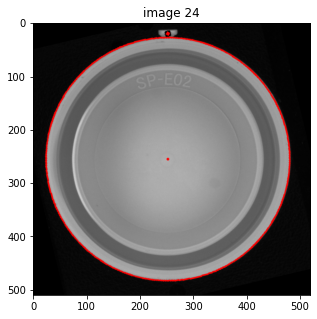

####################################################


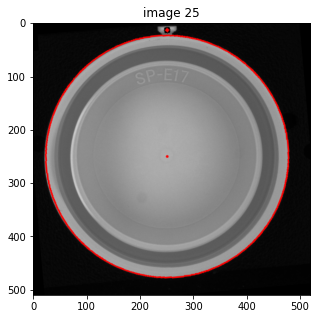

####################################################


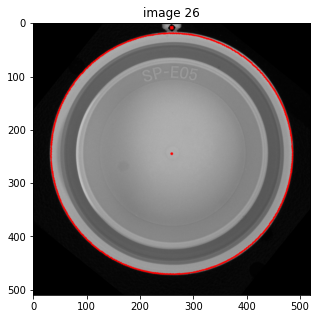

####################################################


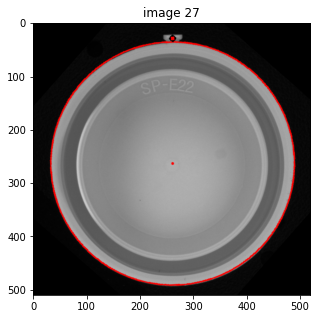

####################################################


In [48]:

tabs = list()
rotated_images= list()
centers = list()
for i in range(0,len(cb_images)):
    focus = cb_images[i].copy()
    original = cv2.cvtColor(cropped_images[i],cv2.COLOR_BGR2RGB).copy()
    circles = find_best_circle(focus)
    plt.figure(figsize=(5,5))
    # print("image {} has {} circles".format(i,len(circles)))
    # fig = plt.figure()

    # plt.subplot(2,2,1)
    # highlighted = cropped_images[i]
    tab = cv2.cvtColor(focus,cv2.COLOR_BGR2GRAY).copy()
    
    for (x,y,r) in  circles:
        x_center = x
        y_center = y
        centers.append((x,y,r))
        # print("center has coordinate ({},{}), radius = {}".format(x,y,r))
        highlighted = cv2.circle(focus,(x,y),r,(0,255,255),1)
        original = cv2.circle(original,(x,y),r,(255,0,0),2)
        original = cv2.circle(original,(x,y),1,(255,0,0),2) # adding the centre of the circle
        tab = cv2.circle(tab,(x,y),r,(0,0,0),-1)

    # cv2.imwrite("highlighted_{}.png".format(i),original)


    opened = cv2.blur(tab,(5,5))
    
    opened = cv2.threshold(tab,70,255, type = cv2.THRESH_BINARY,)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opened= cv2.morphologyEx(opened, cv2.MORPH_OPEN,kernel,-1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    opened = cv2.morphologyEx(opened,cv2.MORPH_ERODE,kernel,-1)
    
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    # opened = cv2.morphologyEx(opened,cv2.MORPH_CLOSE,kernel,-1)


    # plt.subplot(1,2,1)
    # plt.imshow(highlighted)
    # plt.title("highlighted")
    # plt.subplot(1,2,2)
    # plt.imshow(opened)
    # plt.title("tab")
    # plt.show()

    labels = measure.label(opened)
    
    # print("labels ={}".format(np.unique(labels)))# never decomment this 
    # print("There are {} blob/s".format(len(np.unique(labels))))

    properties =['area','perimeter','bbox','bbox_area',
                'convex_area',
            'major_axis_length', 'minor_axis_length',
            'eccentricity','label'
            ]
    df = pd.DataFrame(regionprops_table(labels, properties = properties))
    df["compactness"]= df["perimeter"]**2/df["area"]
    df["rectangularity"] = df["area"]/df["bbox_area"]
        
    # if len(np.unique(labels))>=2:
    df= df[df["area"]>=20]
    df= df[df["area"]<=500]
    df=df.sort_values(["compactness","area",'rectangularity'], ascending=[True,False,True])
    # print(df.head(len(np.unique(labels))));
    # print()
    best =df.iloc[0]['label']
    area = df.iloc[0]["area"]
    # print("label {}".format(best)) 
    # print("best blob has label {}".format(best))
    # minr, minc, maxr, maxc = df.iloc[0]["bbox-0"],df.iloc[0]["bbox-1"],df.iloc[0]["bbox-2"],df.iloc[0]["bbox-3"]
    
    
    # labels[labels!=best]=0
    labels[labels==best]=255
    # cv2.rectangle(tab, (minr,minc),(maxr,maxc),(255,0,0),1)
    # plt.imshow(labels,cmap="gray")
    # plt.add_patch(rect)
    # plt.title("suppressed")
    # plt.show()

    (x_tab,y_tab) = compute_centroid(labels,x,y,area)

    
    angle = compute_rotation_angle(x_tab-x_center,y_tab-y_center)
    

    # print("we need to rotate by {} degree".format(angle))    
    cv2.circle(original,(x_tab,y_tab),1,(0,0,0),10) # adding the barycenter of the centroid
    
    original = cv2.circle(original,(x_tab,y_tab),2,(255,0,0),3)
    rotated_image= rotate(original,angle)
   
    plt.imshow(rotated_image,cmap="gray")
    plt.title("image {}".format(i+1))
    # plt.title("degree {}".format(np.round(angle,2)))
    plt.show()
    rotated_images.append(rotated_image)

    cv2.circle(tab,(x, y),1,(255,255,255),10)
    print("####################################################")
   

In [49]:
# for image in rotated_images:
    # plt.imshow(image,cmap="gray")
    # plt.show()

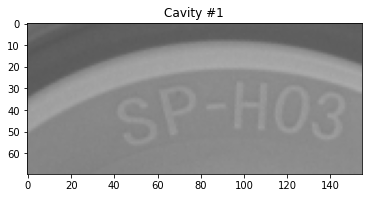

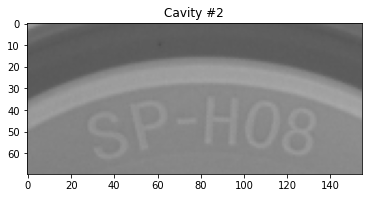

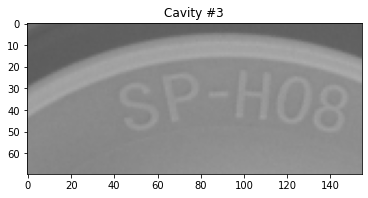

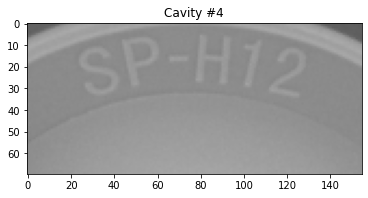

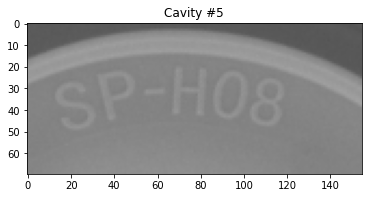

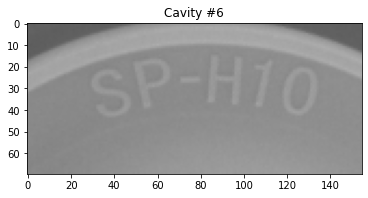

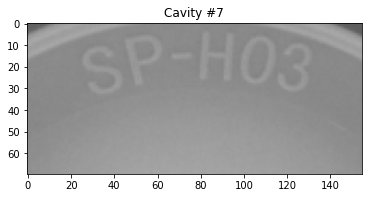

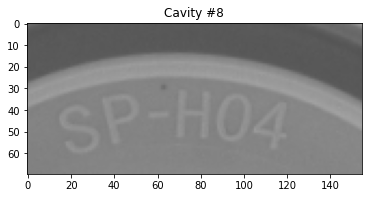

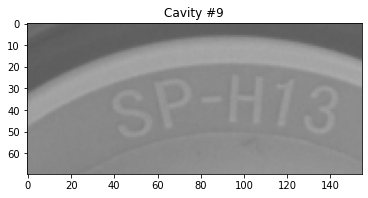

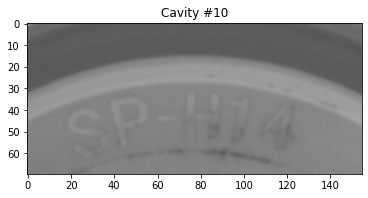

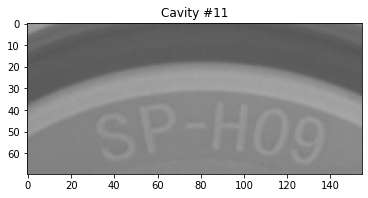

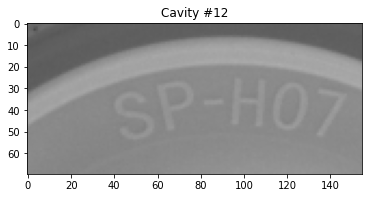

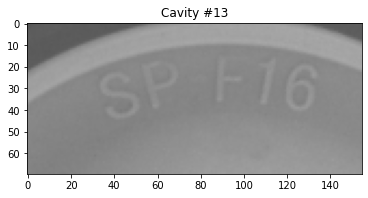

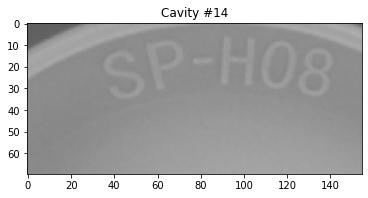

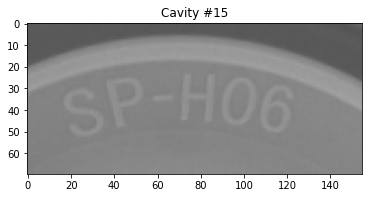

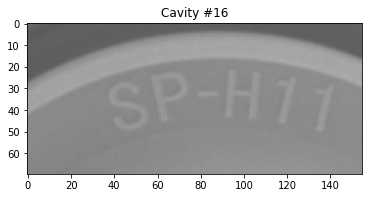

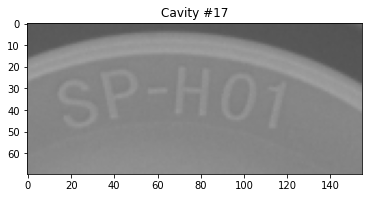

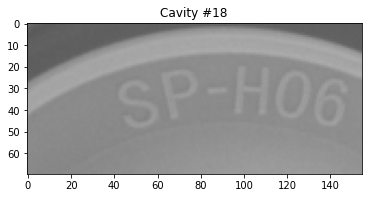

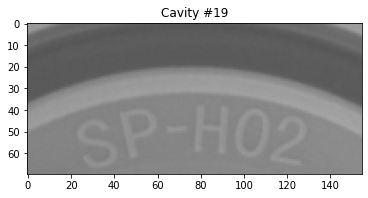

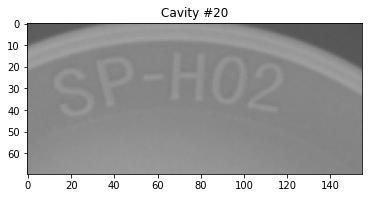

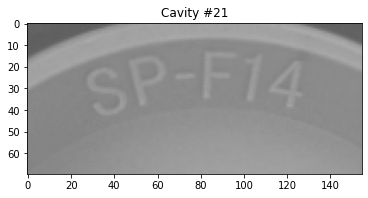

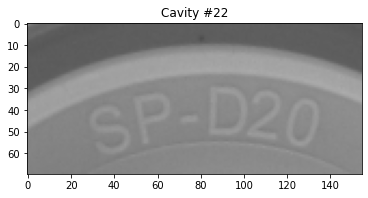

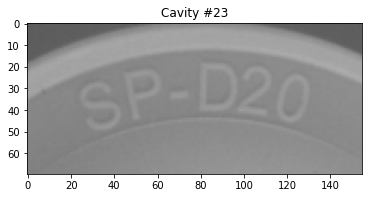

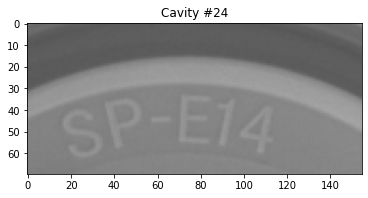

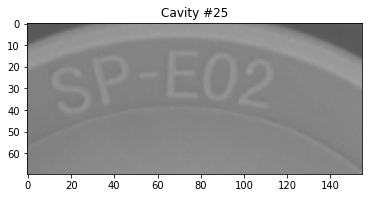

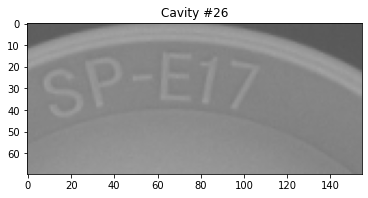

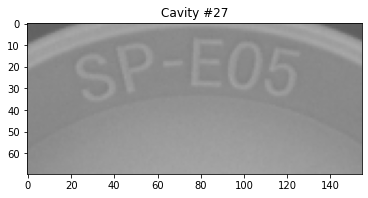

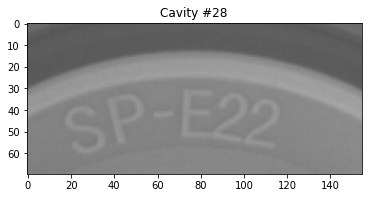

In [56]:
cavity_numbers = list()
for i in range(len(rotated_images)):
    image = rotated_images[i]
    (x,y,r) = centers[i]
    # print("the center is ({},{})".format(x,y))
    delta_x = 35
    x-=145
    delta_y = 75
    # x-delta_x:x+delta_x
    # y-=20
    # y-delta_y:y+delta_y
    cavity_number = image[x-delta_x:x+delta_x, y-delta_y+10:y+delta_y+15].copy()

    cavity_numbers.append(cavity_number)
    plt.imshow(cavity_number,cmap="gray")
    plt.title("Cavity #{}".format(i+1))
    plt.show()

    # plt.imwrite("Cavity_{}.png".format(i),cavity_number) # 




In [61]:

for i in range (len(cavity_numbers)):
    (x,y,r)= centers[i]
    image =rotated_images[i]

    res = warp_polar(image
                        ,center=(x,y)
                        ,radius=r
                        ,scaling='log')

    plt.imshow(res,cmap="gray")
    plt.show()
    # polarImage = cavity_numbers[i]  cartesian = warp_polar(polarImage, center=(x,y),radius=r, multichannel=True)
    
    # cartesian = warp_polar(polarImage, center=(x,y),radius=r, multichannel=True)
    

    # # plt.figure()
    # # plt.imshow(polarImage, origin='lower')

    # plt.figure()
    # plt.imshow(cartesian)
    # plt.show()

ValueError: Input array must be 2 dimensions when `multichannel=False`, got 3